<a href="https://colab.research.google.com/github/dennisb1239/dukeC2W4-project/blob/master/predicting_house_prices_with_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression Model for Predicting House Prices

This Kaggle dataset consists of roughly 3,000 property listings (observations), each with 79 property attributes, and our target, sale price. The goal is to use EDA, data cleaning, preprocessing and linear model to predict home prices given the features of the home. I will follow these steps to a successful submission:

1. Exploratory Data Analysis
1. Data Preprocessing
    1. Fixing Skewness and Outliers
    1. Encoding Categorical Data
    1. Imputing Missing Values
1. Modelling
1. Submission

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
from math import sqrt
from scipy.stats import skew
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
plt.style.use(style='fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)

# Exploratory Data Analysis

In this initial investigations on data will be performed to to develop an understanding of the data, discover patterns and spot anomalies.

In [3]:
# load the datasets into dataframe
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
# show the first few records of train set
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# check the number of records and columns in both of datasets
print('No. of records in train dataset: ', len(train.index))
print('No. of columns in train dataset: ', len(train.columns))
print('No. of records in test dataset: ', len(test.index))
print('No. of columns in test dataset: ', len(test.columns))

No. of records in train dataset:  1460
No. of columns in train dataset:  81
No. of records in test dataset:  1459
No. of columns in test dataset:  80


In [6]:
# check the missing values
print ('Total missing values in train set', sum(train.isna().sum()))
print ('Total missing values in test set', sum(test.isna().sum()))

Total missing values in train set 6965
Total missing values in test set 7000


In [7]:
# check the missing values
print ('Total missing values in train set', sum(train.isna().sum()))
print ('Total missing values in test set', sum(test.isna().sum()))

Total missing values in train set 6965
Total missing values in test set 7000


In [8]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The aobve line code shows that the average sale price of a house is close to 180,000 with most of the values falling within the 130,000 to 215,000 range. Next step is to show the relationship between the columns to examine the correlations between the features and the target.

In [9]:
numeric_cols = train.select_dtypes(include = [np.number])
corr = numeric_cols.corr()
print ('The Most Correlated Features with SalePrice:'), print (corr['SalePrice'].sort_values(ascending = False)[:10], '\n')
print ('The Most Uncorrelated Features with SalePrice:'), print (corr['SalePrice'].sort_values(ascending = False)[-5:])

The Most Correlated Features with SalePrice:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64 

The Most Uncorrelated Features with SalePrice:
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


(None, None)

The most correlated features to sale price were the overall quality score (79%), above-ground living area (71%), garage area (64%), and number-of-car garage (62%). Next step is to plot each variable individually against SalePrice in a scatter plot to check outliers as outliers can affect the regression model by pulling the estimated regression line further away from the true population regression line.

Text(0.5, 0, 'GrLivArea (Above grade "ground" living area square feet)')

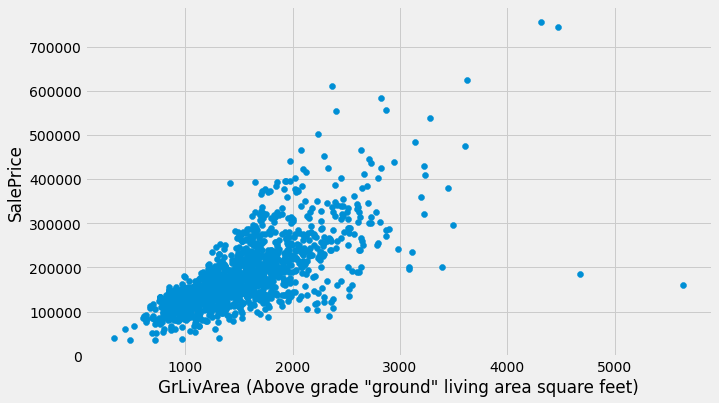

In [10]:
plt.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea (Above grade "ground" living area square feet)')

At first glance, there are increases in living area correspond to increases in price, with few outliers.

Text(0.5, 0, 'GarageArea')

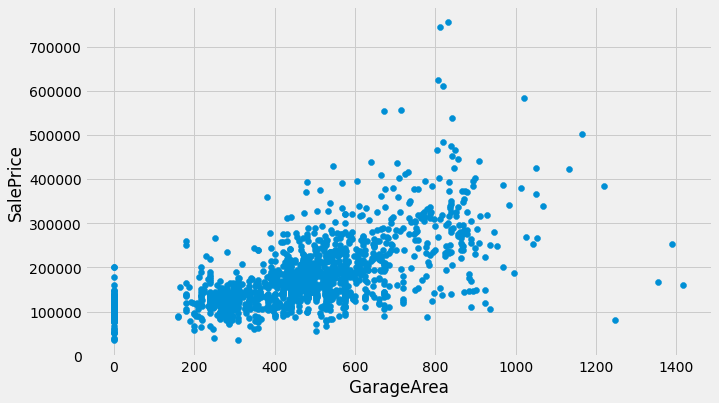

In [11]:
plt.scatter(x = train['GarageArea'], y = train['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GarageArea')

So there are many homes with 0 for GarageArea and there are a few outliers as well!

# Data Preprocessing

In this section the data is prepared (transformed, encoded, etc) to make it suitable for a building and training machine learning model. I chose to manually remove certain extreme outliers in the dataset to produce a better fit.

In [12]:
# remove GrLivArea outliers
train = train[train['GrLivArea'] < 4500]

In [13]:
# remove GarageArea outliers
train = train[train['GarageArea'] < 1200]

In [14]:
# drop columns with percentage of missing values > 80%
train_percentage = train.isnull().sum() / train.shape[0]
print (train_percentage[train_percentage > 0.80])
train = train.drop(train_percentage[train_percentage > 0.80].index, axis = 1)

Alley          0.937414
PoolQC         0.995873
Fence          0.806740
MiscFeature    0.963549
dtype: float64


In [15]:
# do the same with test data
test_percentage = test.isnull().sum() / test.shape[0]
print (test_percentage[test_percentage > 0.80])
test = test.drop(test_percentage[test_percentage > 0.80].index, axis = 1)

Alley          0.926662
PoolQC         0.997944
Fence          0.801234
MiscFeature    0.965045
dtype: float64


In [16]:
# encode categorical variables
le = preprocessing.LabelEncoder()
for name in train.columns:
    if train[name].dtypes == 'O':
        train[name] = train[name].astype(str)
        le.fit(train[name])
        train[name] = le.transform(train[name])

In [17]:
# do the same for testset
for name in test.columns:
    if test[name].dtypes == 'O':
        test[name] = test[name].astype(str)
        le.fit(test[name])
        test[name] = le.transform(test[name])

There are many ways to handle NaN values, whether to fill with the mean or median, however strings cannot be averaged or median-ed. One way to fill missing values is to impute these missing values according to their probability of occuring in the dataset to avoid single-valued imputation that impacts the quality of inference and prediction.

In [18]:
# fill missing values based on probability of occurrence
for column in train.columns:
    null_vals = train.isnull().values
    a, b = np.unique(train.values[~null_vals], return_counts = 1)
    train.loc[train[column].isna(), column] = np.random.choice(a, train[column].isnull().sum(), p = b / b.sum())

In [19]:
# apply log transformation to reduce skewness over .75 by taking log(feature + 1)
skewed_train = train.apply(lambda x: skew(x.dropna()))
skewed_train = skewed_train[skewed_train > .75]
train[skewed_train.index] = np.log1p(train[skewed_train.index])

In [20]:
# deal with the skewness in the test data
skewed_test = test.apply(lambda x: skew(x.dropna()))
skewed_test = skewed_test[skewed_test > .75]
test[skewed_test.index] = np.log1p(test[skewed_test.index])

# Modelling

I will perform a simple linear regression on the dataset to predict house prices. In order to train out the regression model, we need to first split up the data into an X list that contains the features to train on, and a y list with the target variable, in this case, the Price column.

In [21]:
#X = train.drop(['SalePrice', 'Id'], axis = 1)
X = train['OverallQual'].values
X = X.reshape(-1,1)
y = train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Split the data into training and testing set using scikit-learn train_test_split function. We are using 80% of the data for training and 20% for testing, train_test_split() returns four objects:

- **X_train**: the subset of our features used for training
- **X_test**: the subset which will be our ‘hold-out’ set – what we’ll use to test the model
- **y_train**: the target variable SalePrice which corresponds to X_train
- **y_test**: the target variable SalePrice which corresponds to X_test

Now we will import the linear regression class, create an object of that class, which is the linear regression model.

In [22]:
lr = linear_model.LinearRegression()

Then using the fit method to "fit" the model to the dataset. What this does is nothing but make the regressor "study" the data and "learn" from it.

In [23]:
model = lr.fit(X_train, y_train)

R-squared is the measure of how close the data are to the fitted regression line, in other words it measures the strength of the relationship between the model and the SalePrice on a convenient 0 – 100% scale.

In [24]:
# make predictions based on model
predictions = model.predict(X_test)

There are three primary metrics used to evaluate linear models. These are:
* Mean absolute error (MAE)
* Mean squared error (MSE)
* Root mean squared error (RMSE)

**MAE**: The easiest to understand. Represents average error.<br>
**MSE**: Similar to MAE but noise is exaggerated and larger errors are "punished". It is harder to interpret than MAE as it's not in base units, however, it is generally more popular.<br>
**RMSE**: Most popular metric, similar to MSE, however, the result is square rooted to make it more interpretable as it's in base units. It is recommended that RMSE be used as the primary metric to interpret your model.

In [25]:
print ('MAE is:', mean_absolute_error(y_test, predictions))
print ('MSE is:', mean_squared_error(y_test, predictions))
print ('RMSE is:', sqrt(mean_squared_error(y_test, predictions)))

MAE is: 0.16737371294219575
MSE is: 0.05040884918817278
RMSE is: 0.22451915104991108


Text(0.5, 1.0, 'Linear Regression Model')

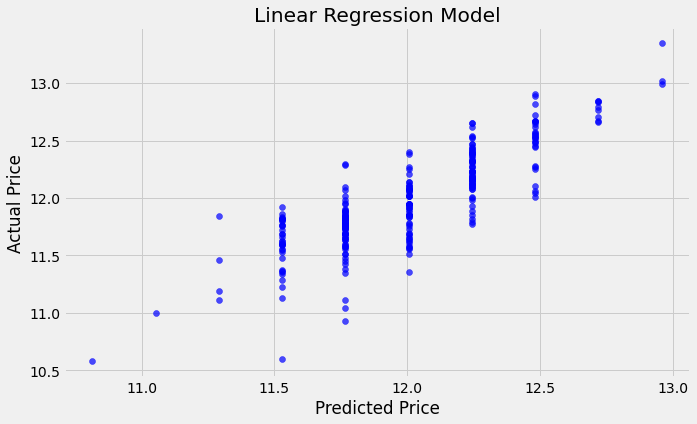

In [26]:
# alpha helps to show overlapping data
plt.scatter(predictions, y_test, alpha = 0.7, color = 'b')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Predicted Price')

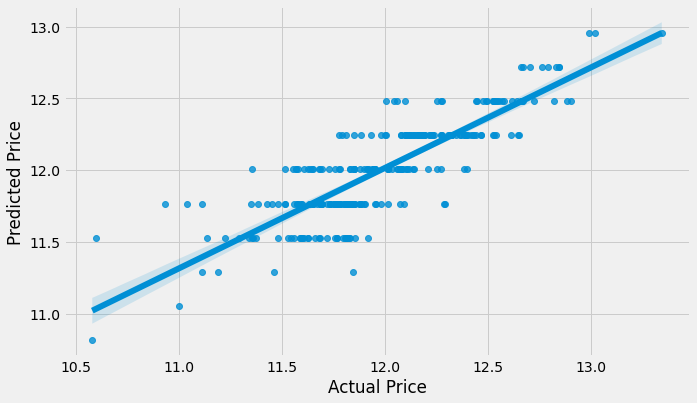

In [29]:
plot = sns.regplot(y_test, predictions)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")

# Export Model

In [30]:
import joblib

In [31]:
joblib.dump(model, 'model.joblib')

['model.joblib']